In [4]:
import os
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [6]:
device=torch.device("cuda" if torch.cuda.is_available() else"cpu")
device

device(type='cpu')

##Load data

In [16]:
image_transforms=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [19]:
dataset_path="./dataset"
dataset=datasets.ImageFolder(root=dataset_path,transform=image_transforms)
len(dataset)

2300

In [20]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [21]:
num_classes=len(dataset.classes)
num_classes

6

In [24]:
train_size=int(0.75*len(dataset))
val_size=len(dataset)-train_size
train_size,val_size

(1725, 575)

In [25]:
from torch.utils.data import random_split
train_dataset,val_dataset=random_split(dataset,[train_size,val_size])

In [26]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=True)


In [27]:
for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [35]:
labels[1]

tensor(0)

In [36]:
images[1].shape

torch.Size([3, 224, 224])

In [37]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


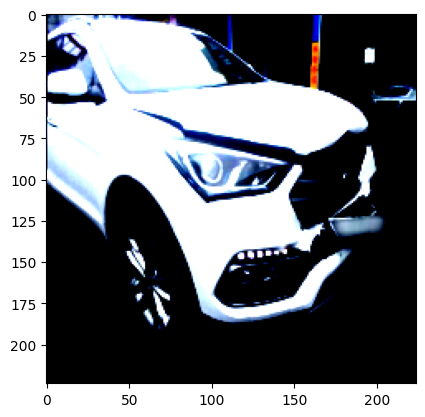

In [38]:
plt.imshow(images[1].permute(1,2,0))

###model1 CNN

In [43]:
class CarClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),#(16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#(16,112,122)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),#(32,112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#(32,56,56)
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),#(64,56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#(64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        )

    def forward(self,x):
        x=self.network(x)
        return x
               
            
    

In [44]:
model=CarClassifierCNN(num_classes=num_classes)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [72]:
def train_model(model,criterion,optimizer,epochs=5):
    start=time.time()
    for epoch in range(epochs): 
        model.train()
        running_loss=0.0
        for batch_num,(images,labels) in enumerate (train_loader):
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            if (batch_num+1)%10==0:
                print(f"Batch=:{batch_num+1},Epoch:{epoch+1},loss:{loss.item():.2f}")
            running_loss +=loss.item() * images.size(0)
        epoch_loss=running_loss/len(train_loader.dataset)
        print(f"Epoch[{epoch+1},{epochs}],Avg_loss:{epoch_loss:.4f}")

        model.eval()
        correct=0
        total=0
        all_labels=[]
        all_predictions=[]

        with torch.no_grad():
            for images,labels in val_loader:
                output=model(images)
                _,predicted=torch.max(output.data,1)
                total+=labels.size(0)
                correct += (predicted==labels).sum().item()
                all_labels.extend(labels.numpy())
                all_predictions.extend(predicted.numpy())
            
            print(f"validation_accuracy:{100*correct/total:.2f}%")
    end=time.time()
    print(f" execution time={end-start}")
    return all_labels,all_predictions
        

In [75]:
all_labels,all_predictions=train_model(model,criterion,optimizer,epochs=5)

Batch=:10,Epoch:1,loss:0.62
Batch=:20,Epoch:1,loss:0.72
Batch=:30,Epoch:1,loss:0.97
Batch=:40,Epoch:1,loss:0.74
Batch=:50,Epoch:1,loss:0.66
Epoch[1,5],Avg_loss:0.6666
validation_accuracy:58.26%
Batch=:10,Epoch:2,loss:0.62
Batch=:20,Epoch:2,loss:0.87
Batch=:30,Epoch:2,loss:0.78
Batch=:40,Epoch:2,loss:0.66
Batch=:50,Epoch:2,loss:0.93
Epoch[2,5],Avg_loss:0.6501
validation_accuracy:60.00%
Batch=:10,Epoch:3,loss:0.50
Batch=:20,Epoch:3,loss:0.57
Batch=:30,Epoch:3,loss:0.37
Batch=:40,Epoch:3,loss:0.42
Batch=:50,Epoch:3,loss:0.68
Epoch[3,5],Avg_loss:0.5704
validation_accuracy:58.78%
Batch=:10,Epoch:4,loss:0.56
Batch=:20,Epoch:4,loss:0.53
Batch=:30,Epoch:4,loss:0.40
Batch=:40,Epoch:4,loss:0.57
Batch=:50,Epoch:4,loss:0.38
Epoch[4,5],Avg_loss:0.4887
validation_accuracy:62.43%
Batch=:10,Epoch:5,loss:0.51
Batch=:20,Epoch:5,loss:0.75
Batch=:30,Epoch:5,loss:0.37
Batch=:40,Epoch:5,loss:0.55
Batch=:50,Epoch:5,loss:0.66
Epoch[5,5],Avg_loss:0.5150
validation_accuracy:63.48%
 execution time=343.7995719909

In [83]:
class CarClassifierCNNwithRegularization(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),#(16,224,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#(16,112,122)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),#(32,112,112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#(32,56,56)
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),#(64,56,56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#(64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,num_classes)
        )

    def forward(self,x):
        x=self.network(x)
        return x

In [84]:
model=CarClassifierCNNwithRegularization(num_classes=num_classes)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)
train_model(model,criterion,optimizer,epochs=10)

Batch=:10,Epoch:1,loss:9.48
Batch=:20,Epoch:1,loss:4.51
Batch=:30,Epoch:1,loss:2.02
Batch=:40,Epoch:1,loss:1.47
Batch=:50,Epoch:1,loss:1.55
Epoch[1,10],Avg_loss:7.1795
validation_accuracy:46.61%
Batch=:10,Epoch:2,loss:1.85
Batch=:20,Epoch:2,loss:1.48
Batch=:30,Epoch:2,loss:1.61
Batch=:40,Epoch:2,loss:1.30
Batch=:50,Epoch:2,loss:1.55
Epoch[2,10],Avg_loss:1.3715
validation_accuracy:46.78%
Batch=:10,Epoch:3,loss:1.12
Batch=:20,Epoch:3,loss:1.18
Batch=:30,Epoch:3,loss:1.15
Batch=:40,Epoch:3,loss:0.99
Batch=:50,Epoch:3,loss:1.32
Epoch[3,10],Avg_loss:1.2690
validation_accuracy:53.57%
Batch=:10,Epoch:4,loss:1.01
Batch=:20,Epoch:4,loss:1.41
Batch=:30,Epoch:4,loss:1.02
Batch=:40,Epoch:4,loss:1.11
Batch=:50,Epoch:4,loss:1.18
Epoch[4,10],Avg_loss:1.2101
validation_accuracy:50.96%
Batch=:10,Epoch:5,loss:1.02
Batch=:20,Epoch:5,loss:1.41
Batch=:30,Epoch:5,loss:1.12
Batch=:40,Epoch:5,loss:1.32
Batch=:50,Epoch:5,loss:1.06
Epoch[5,10],Avg_loss:1.1718
validation_accuracy:52.17%
Batch=:10,Epoch:6,loss:1.

([np.int64(1),
  np.int64(3),
  np.int64(2),
  np.int64(2),
  np.int64(3),
  np.int64(1),
  np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(5),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(4),
  np.int64(0),
  np.int64(3),
  np.int64(4),
  np.int64(3),
  np.int64(3),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(4),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(5),
  np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(4),
  np.int64(2),
  np.int64(0),
  np.int64(5),
  np.int64(3),
  np.int64(0),
  np.int64(4),
  np.int64(5),
  np.int64(1),
  np.int64(2),
  np.int64(5),
  np.int64(2),
  np.int64(3),
  np.int64(5),
  np.int64(1),
  np.int64(4),
  np.int64(2),
  np.int64(5),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64

In [96]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model=models.efficientnet_b0(weights='DEFAULT')
        for param in self.model.parameters():
            param.requires_grad=False
        in_features=self.model.classifier[1].in_features
        self.model.classifier=nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features,num_classes)
        )
    def forward(self,x):
        x=self.model(x)
        return x

In [97]:
model=CarClassifierEfficientNet(num_classes=num_classes)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=0.001)
train_model(model,criterion,optimizer,epochs=10)

Batch=:10,Epoch:1,loss:1.72
Batch=:20,Epoch:1,loss:1.65
Batch=:30,Epoch:1,loss:1.53
Batch=:40,Epoch:1,loss:1.25
Batch=:50,Epoch:1,loss:1.49
Epoch[1,10],Avg_loss:1.4950
validation_accuracy:57.57%
Batch=:10,Epoch:2,loss:1.26
Batch=:20,Epoch:2,loss:1.08
Batch=:30,Epoch:2,loss:1.11
Batch=:40,Epoch:2,loss:1.24
Batch=:50,Epoch:2,loss:1.00
Epoch[2,10],Avg_loss:1.1419
validation_accuracy:63.65%
Batch=:10,Epoch:3,loss:0.96
Batch=:20,Epoch:3,loss:0.89
Batch=:30,Epoch:3,loss:0.98
Batch=:40,Epoch:3,loss:0.93
Batch=:50,Epoch:3,loss:1.11
Epoch[3,10],Avg_loss:1.0226
validation_accuracy:65.39%
Batch=:10,Epoch:4,loss:0.93
Batch=:20,Epoch:4,loss:0.84
Batch=:30,Epoch:4,loss:0.95
Batch=:40,Epoch:4,loss:0.86
Batch=:50,Epoch:4,loss:1.01
Epoch[4,10],Avg_loss:0.9599
validation_accuracy:64.70%
Batch=:10,Epoch:5,loss:1.17
Batch=:20,Epoch:5,loss:0.85
Batch=:30,Epoch:5,loss:1.00
Batch=:40,Epoch:5,loss:0.93
Batch=:50,Epoch:5,loss:0.96
Epoch[5,10],Avg_loss:0.9118
validation_accuracy:65.04%
Batch=:10,Epoch:6,loss:1.

([np.int64(4),
  np.int64(1),
  np.int64(5),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(4),
  np.int64(2),
  np.int64(1),
  np.int64(3),
  np.int64(5),
  np.int64(2),
  np.int64(1),
  np.int64(4),
  np.int64(2),
  np.int64(5),
  np.int64(1),
  np.int64(4),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(4),
  np.int64(5),
  np.int64(5),
  np.int64(1),
  np.int64(4),
  np.int64(2),
  np.int64(2),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(4),
  np.int64(5),
  np.int64(3),
  np.int64(2),
  np.int64(5),
  np.int64(0),
  np.int64(5),
  np.int64(0),
  np.int64(4),
  np.int64(3),
  np.int64(0),
  np.int64(2),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(4),
  np.int64(3),
  np.int64(3),
  np.int64(5),
  np.int64(0),
  np.int64(5),
  np.int64(1),
  np.int64(3),
  np.int64(2),
  np.int64(4),
  np.int64(5),
  np.int64(3),
  np.int64(4),
  np.int64(1),
  np.int64(5),
  np.int64(1),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64

###MODEL TRAINING 4 RESNET

In [111]:
class CarClassifierResNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model=models.resnet50(weights='DEFAULT')
        for param in self.model.parameters():
            param.requires_grad=False
        for param in self.model.layer4.parameters():
            param.requires_grad=True
        in_features=self.model.fc.in_features
        self.model.fc=nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_features,num_classes)
        )
    def forward(self,x):
        x=self.model(x)
        return x

In [113]:
model=CarClassifierResNet(num_classes=num_classes)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=0.005)
train_model(model,criterion,optimizer,epochs=10)

Batch=:10,Epoch:1,loss:1.20
Batch=:20,Epoch:1,loss:0.92
Batch=:30,Epoch:1,loss:0.92
Batch=:40,Epoch:1,loss:0.43
Batch=:50,Epoch:1,loss:0.60
Epoch[1,10],Avg_loss:0.9106
validation_accuracy:71.65%
Batch=:10,Epoch:2,loss:0.62
Batch=:20,Epoch:2,loss:0.43
Batch=:30,Epoch:2,loss:0.46
Batch=:40,Epoch:2,loss:0.43
Batch=:50,Epoch:2,loss:0.40
Epoch[2,10],Avg_loss:0.5239
validation_accuracy:77.39%
Batch=:10,Epoch:3,loss:0.21
Batch=:20,Epoch:3,loss:0.26
Batch=:30,Epoch:3,loss:0.61
Batch=:40,Epoch:3,loss:0.29
Batch=:50,Epoch:3,loss:0.63
Epoch[3,10],Avg_loss:0.3478
validation_accuracy:73.04%
Batch=:10,Epoch:4,loss:0.29
Batch=:20,Epoch:4,loss:0.23
Batch=:30,Epoch:4,loss:0.29
Batch=:40,Epoch:4,loss:0.26
Batch=:50,Epoch:4,loss:0.46
Epoch[4,10],Avg_loss:0.3168
validation_accuracy:76.00%
Batch=:10,Epoch:5,loss:0.20
Batch=:20,Epoch:5,loss:0.14
Batch=:30,Epoch:5,loss:0.74
Batch=:40,Epoch:5,loss:0.16
Batch=:50,Epoch:5,loss:0.28
Epoch[5,10],Avg_loss:0.2318
validation_accuracy:77.91%
Batch=:10,Epoch:6,loss:0.

([np.int64(0),
  np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(1),
  np.int64(5),
  np.int64(0),
  np.int64(1),
  np.int64(5),
  np.int64(5),
  np.int64(2),
  np.int64(5),
  np.int64(0),
  np.int64(0),
  np.int64(5),
  np.int64(1),
  np.int64(3),
  np.int64(2),
  np.int64(3),
  np.int64(2),
  np.int64(4),
  np.int64(4),
  np.int64(5),
  np.int64(3),
  np.int64(5),
  np.int64(4),
  np.int64(3),
  np.int64(5),
  np.int64(4),
  np.int64(5),
  np.int64(3),
  np.int64(5),
  np.int64(4),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(3),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(0),
  np.int64(5),
  np.int64(5),
  np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(4),
  np.int64(0),
  np.int64

In [115]:
torch.save(model.state_dict(),'saved_model.pth')